# Importing Required Libraries

First, we are importing the libraries and modules that are required for running this notebook.

In [1]:
#import general packages
import os
import argparse
import logging
import sys
from typing import Dict, List
from dpu_utils.utils.richpath import RichPath
import pickle

import torch
from tqdm.notebook import tqdm
import pandas as pd

# Setting up local details:
# This should be the location of the checkout of the THEMAP repository:
repo_path = os.path.dirname(os.path.abspath(""))
CHECKOUT_PATH = repo_path
DATASET_PATH = os.path.join(repo_path, "datasets")

os.chdir(CHECKOUT_PATH)
sys.path.insert(0, CHECKOUT_PATH)

In [28]:
from third_party.otdd.otdd.pytorch.datasets import MolDataset, load_molecule_data
from third_party.otdd.otdd.pytorch.distance import DatasetDistance

ot.gpu not found - coupling computation will be in cpu


In [82]:
# import visualization packages
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import pandas as pd
from themap.utils import compute_task_hardness_from_distance_matrix, normalize, internal_hardness, otdd_hardness
from themap.data import MoleculeDatapoint, MoleculeDataset


light_color = plt.get_cmap("plasma").colors[170]
dark_color = "black"

matplotlib.rcParams.update(
    {
        "pgf.texsystem": "pdflatex",
        "font.family": "serif",
        "font.serif": "Computer Modern Roman",
        "font.size": 20,
        "text.usetex": True,
        "pgf.rcfonts": False,
    }
)

# Create source and target datasets (Data)

In [98]:
source_dataset_path = RichPath.create(os.path.join(DATASET_PATH, "train", "CHEMBL1023359.jsonl.gz"))
target_dataset_path = RichPath.create(os.path.join(DATASET_PATH, "test", "CHEMBL2219358.jsonl.gz"))

source_dataset = MoleculeDataset.load_from_file(source_dataset_path)
target_dataset = MoleculeDataset.load_from_file(target_dataset_path)

In [99]:
## compute and load the embeddings
molecule_feaurizer = "gin_supervised_infomax"
source_features = source_dataset.get_dataset_embedding(molecule_feaurizer)
target_features = target_dataset.get_dataset_embedding(molecule_feaurizer)
assert source_features.shape[1] == target_features.shape[1]

In [100]:
source_dataset_otdd = MolDataset(source_dataset)
target_dataset_otdd = MolDataset(target_dataset)

In [101]:
source_dataset_loader = load_molecule_data(source_dataset)
target_dataset_loader = load_molecule_data(target_dataset)

In [102]:
# Instantiate distance
dist = DatasetDistance(source_dataset_loader, target_dataset_loader,
                       inner_ot_method = 'exact',
                       debiased_loss = True,
                       p = 2, entreg = 1e-1,
                       device='cuda' if torch.cuda.is_available() else 'cpu')

d = dist.distance(maxsamples = 1000)
print(f'OTDD(src,tgt)={d}')

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

OTDD(src,tgt)=7.07429838180542


## Calculate chemcial distance between target datasets with all the source datasets

In [ ]:
import glob
source_datasets_path = glob.glob(os.path.join(DATASET_PATH, "train", "CHEMBL*"))
target_datasets_path = glob.glob(os.path.join(DATASET_PATH, "test", "CHEMBL*"))
chem_distances = {}
for target_path in tqdm(target_datasets_path):
    chem_distance = {}
    target_dataset_path = RichPath.create(target_path)
    target_dataset = MoleculeDataset.load_from_file(target_dataset_path)
    target_features = target_dataset.get_dataset_embedding(molecule_feaurizer)
    target_dataset_otdd = MolDataset(target_dataset)
    target_dataset_loader = load_molecule_data(target_dataset)
    for source_path in source_datasets_path:
        source_dataset_path = RichPath.create(source_path)
        source_dataset = MoleculeDataset.load_from_file(source_dataset_path)
        source_features = source_dataset.get_dataset_embedding(molecule_feaurizer)
        source_dataset_otdd = MolDataset(source_dataset)
        source_dataset_loader = load_molecule_data(source_dataset)

        dist = DatasetDistance(source_dataset_loader, target_dataset_loader,
                               inner_ot_method = 'exact',
                               debiased_loss = True,
                               p = 2, entreg = 1e-1,
                               device='cuda' if torch.cuda.is_available() else 'cpu')
        
        d = dist.distance(maxsamples = 1000)
        print(f'OTDD({source_dataset.task_id},{target_dataset.task_id})= {d}')
        chem_distance[source_dataset.task_id] = d.cpu().item()
    chem_distances[target_dataset.task_id] = chem_distance


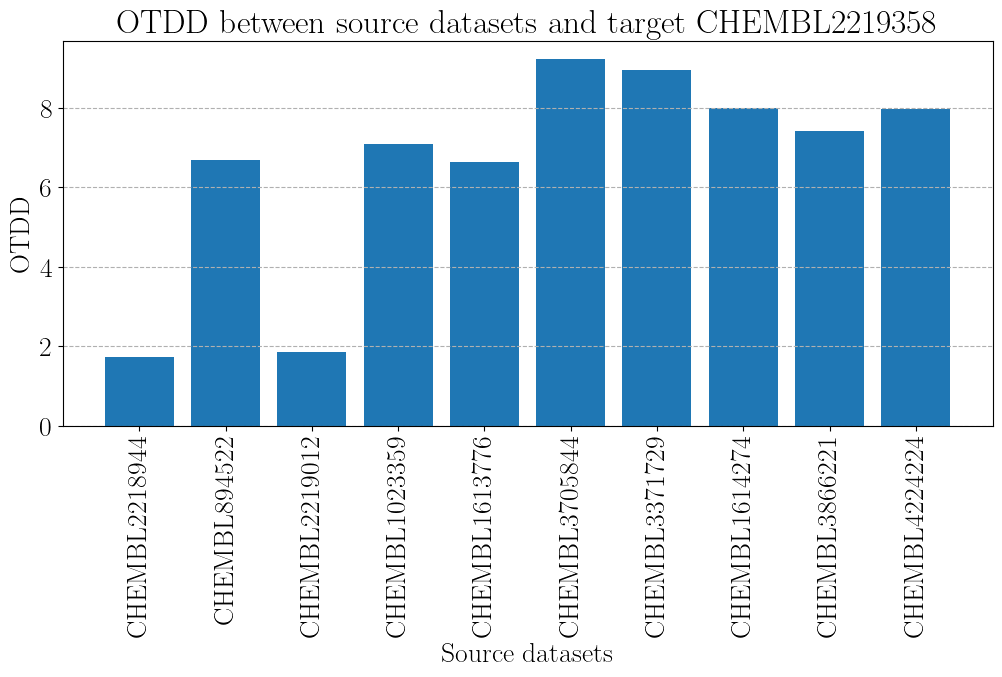

In [124]:
## Choose your target from chem_distances.keys()
chem_dist = chem_distances['CHEMBL2219236']
fig = plt.figure(figsize=(12, 5))
plt.bar(chem_dist.keys(), chem_dist.values())
plt.xlabel('Source datasets')
plt.ylabel('OTDD')
plt.title(f'OTDD between source datasets and target {target_dataset.task_id}')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=1.0)
plt.show()

In [121]:
chem_distances.keys()

dict_keys(['CHEMBL2219236', 'CHEMBL1963831', 'CHEMBL2219358'])